# overview

-   使用 logging module 的意义: 作为 python world 的标准 logging 机制,
    只要大家都使用 logging 输出自己的日志, 当一个应用由多个组件构成时,
    这些日志信息可以很好地结合在一起, 成为一个 well-organized 整体.
    而不是各自独立, 各有各的样子, 让日志乱七八糟.

# architecture
## components
-   Loggers expose the interface that application code directly uses.
-   Handlers send the log records (created by loggers) to the appropriate
    destination.
-   Filters provide a finer grained facility for determining which log records
    to output.
-   Formatters specify the layout of log records in the final output.

## workflow

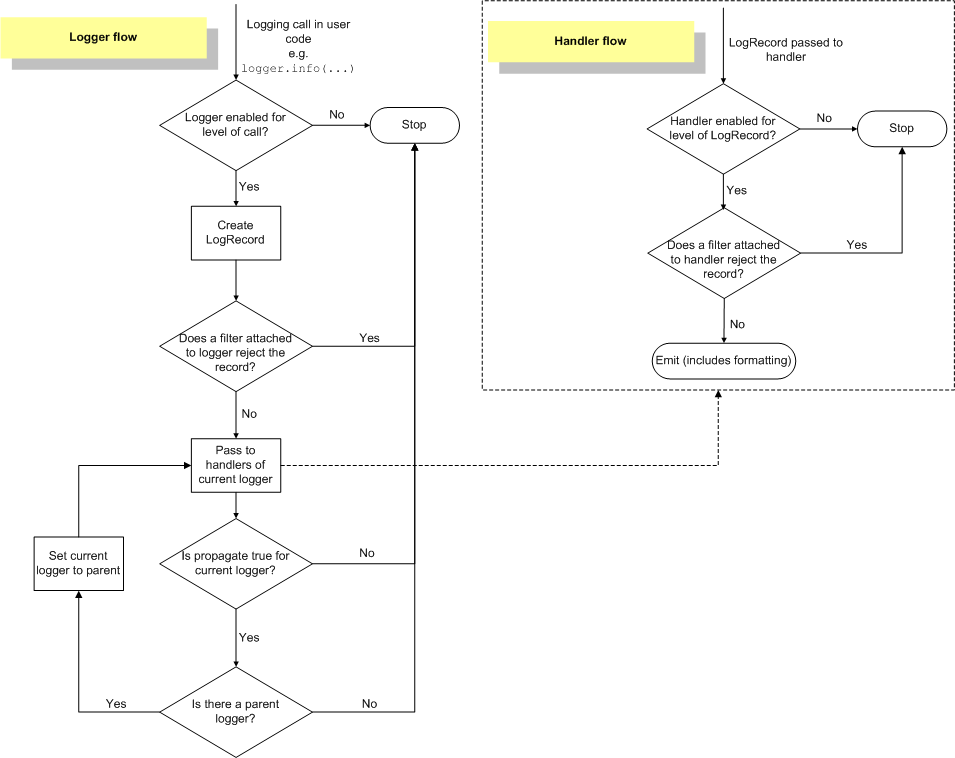

-   总共几次过滤:
    *   global disabled level 过滤
    *   logger effective level 过滤
    *   logger filters 过滤
    *   handler effective level 过滤
    *   handler filter 过滤

-   一个 Logger, 如果对于某个 logging level 没有 enabled (`.isEnabledFor()`),
    相应的 log call (`.debug`, `.info`, etc.) 立即返回, 不生成 `LogRecord` (因
    为不调用 `._log()`). 这样几乎没有 overhead.

-   logger 和 handler 上都可以有 effective level 和 filter. 这是不同层次的过滤.
    前者考虑一个 logger 是否会处理 log call; 后者考虑如果该 logger 处理这个 log
    call, 会输出到哪些地方.

-   For any logger or handler, if any filter returns a false value, the message
    is not processed further.

-   对于设置了 propagation 的 logger, `LogRecord` 在向上层传递时, 不会考虑父级
    logger 的 effective level 和 filters, 而是直接传递给 parent logger
    的各个 handlers.

-   effective level. If a level is not explicitly set on a logger, the level of
    its parent is used instead as its effective level. all ancestors are
    searched until an explicitly set level is found. The root logger always has an
    explicit level set (WARNING by default).

    When deciding whether to process an event, the effective
    level of the logger is used to determine whether the event is passed to the
    logger’s handlers. 而不仅仅是 logger 自己的 level.

-   Child loggers propagate messages up to the handlers associated with their
    ancestor loggers. 因此, 一般只需配置 root logger (包括 level, filters,
    handlers, etc.). 然后在需要写日志的地方创建恰当层级的 child logger, 依靠
    propagation 至 root 输出日志, 它本身不处理.

    只有需要对部分日志进行特殊处理的情况, 才需要对 child loggers 进行单独配置.

-   一条日志由两层 string interpolation 最终生成.
    *   在调用 log call (`.debug()`, `.info()` etc.) 时, `msg` 参数与 `*args`
        参数合成. 这里只能使用 `%`-formatting.

        通过 `LogAdapter` 可进行自定义, [See tips](#alternative-log-call-formatting).
    *   log call 生成的 `LogRecord` instance, 在输出时根据 handler's formatter
        指定的格式进行输出. 此时, `LogRecord` 的数据与 formatter 格式进行 interpolation,
        生成最终的一条日志. 这里可以指定 string format 的格式.

-   输出日志时发生的 exception 默认会被 print to stderr.

# logging levels
log level name to numeric value:

NOTSET 0, DEBUG 10, INFO 20, WARNING 30, ERROR 40, CRITICAL 50.

若需要自定义 log level, 需要相对于 pre-defined level values.

# global configuration
-   `logThreads`
-   `logProcesses`
-   `logMultiprocessing`
-   `raiseExceptions`

# logging configuration
三种方法:
-   Creating loggers, handlers, formatters, and filters explicitly using Python code, then
    calls the appropriate configuration methods.
-   configparser 格式 (INI) 的 logging config file, 使用 `logging.config.fileConfig()`
    加载.
-   create a dict of logging configs, then load it by `logging.config.dictConfig()`

在后两种组织化的日志配置形式中, dict config is recommended. It provides a
superset of the functionality of the config-file-based approach. 因为这个
dict 可以来自任何形式, 例如配置文件 (YAML/JSON etc. 格式), 来自网络 (socket).

## default config

如果程序没有进行任何 logging 配置, 整个 logger hierarchy 上没有任何 handlers,
fallback 使用 `logging.lastResort` handler:
*   class: `StreamHandler`, with `sys.stderr` stream
*   level: WARNING
*   formatter: `Formatter()`. no formatting at all, only message is output.
例如, 如果调用的 library 里执行了 log call, 但主程序没有 logging 配置时会这样.
设置 `logging.lastResort = None` 禁用这个 handler, 这样在没有日志配置时, 完全
没有任何 unexpected output.

如果虽然没有显性进行任何 logging 配置, 但调用了 module-level 的 log call
functions, 后者会自动执行 `basicConfig()`. 此时 root logger 会添加一个 logger,
`lastResort` 不再使用.

## dictConfig

### configuration function

`dictConfig(config)`. configure logging by passing a configuration dict.
Parsing is performed by the DictConfigurator class.

### schema

#### rules

-   对于 formatters, filters, handlers 的 configuring dict 中, 特殊的 `()` key 表示使用
    自定义的 class/factory function 来生成相应的实例. 它的值是 import path string or
    the actual callable object. The callable will be called with the remaining
    items in the configuration sub-dictionary as keyword arguments. 注意对于 `handlers`
    有一些特殊处理. 见下.

    The key `()` has been used as the special key because it is not a valid
    keyword parameter name, and so will not clash with the names of the keyword
    arguments used in the call.

-   External objects. 对于 serialized 至 textual format 的 dict config, 需要区
    分 python object path 与 literal string. 通过 `ext://<import-path>` 语法.
    注意对于在 python 代码中的 dict config, 则没有必要使用.

-   Internal config objects. 指代配置内部的其他地方定义的内容. 通过
    `cfg://<path>` 语法. `<path>` 中, 以 `.` 或 `[<index>]` 指定层级.  例如
    `cfg://handlers.email[subjects][0].1`. Index form key must be used when key
    contains spaces or non-alphanumeric characters. If an index value consists
    only of decimal digits, access will be attempted using the corresponding
    integer value, falling back to the string value if needed.

#### keys
-   `version`. schema version. now is 1. required.

-   `formatters`. a mapping of formatter identifiers to its configuring dict.
    default class is `Formatter`. keys of configuring dict:
    *   `format`, optional.
    *   `datefmt`, optional.
    *   `style`, optional.
    *   `()`.

-   `filters`. a mapping of filter identifiers to its configuring dict. default
    class is `Filter`. keys of configuring dict:
    *   `name`. optional.
    *   `()`

-   `handlers`. a mapping of handler identifiers to its configuring dict. keys
    of configuring dict:
    *   `class` 或 `()` 必须有一个. 且 `()` is prefered.
    *   `level`. optional.
    *   `formatter`. optional. identifier of previously defined formatters.
    *   `filters`. optional. a list of identifier of previously defined
        filters.
    *   All other keys are passed through as keyword arguments to the handler’s
        constructor.

-   `loggers`. a mapping of logger identifiers to its configuring dict. The
    keys are just logger names. configuring dict keys:
    *   `level`. optional.
    *   `filters`. optional. ids.
    *   `handlers`. optional. ids.
    *   `propagate`. optional.
    Loggers do not need to have different types for different instances, so
    there is no support in this configuration schema for user-defined logger
    classes.

-   `root`. root logger. settings like any other logger, except for `propagate`.

-   `incremental`. 什么东西.

-   `disable_existing_loggers`. default True. 将现有的 loggers 全部禁用, 除了在
    本次配置中包含的 logger 以及它们的所有 children loggers.  此外, 如果一个现
    有的 child logger 没有出现在配置中, 将被重置为 propagating logger.

    因此, 需要使用这个参数时要清楚影响范围. 如果是 True, 但是一些现有的 loggers,
    比如 library 中的  loggers, 没有添加在配置中, 会被 disable 掉.

    注意: 在对现有 logger 重新配置时, `dictConfig()` 的逻辑是:

    *   重设 `level` if exists.
    *   重设 `propagate` if exists.
    *   新设置的 `filters` 只添加不删除.
    *   删除现有的 handlers, 添加 `handlers` 设置的.

    因此, filters 尽量在 handlers 中设置, 而不要在 loggers 中设置. 这样便于
    `dictConfig()` 更新配置.

    注意: 对出现在 config dict 中的现有 loggers 的 child loggers, 如果没有明确
    配置, 会自动重置为纯 propagate, 去掉所有配置.  所以如需保留配置, 需要明确重
    新配置.

The ids for loggers are the logger names which would be used programmatically
to obtain a reference to those loggers. The ids for Formatters and Filters can
be any string value (such as brief, precise above) and they are transient, in
that they are only meaningful for processing the configuration dictionary and
used to determine connections between objects, and are not persisted anywhere
when the configuration call is complete.

### DictConfigurator

#### constructor
-   `config`.

#### attributes
-   `importer`

#### methods
-   `configure()`

## fileConfig

## listen for config

-   `logging.config.listen()`. Starts up a socket server on the specified port,
    and listens for new configurations. Logging configurations will be sent as
    a file suitable for processing by `dictConfig()` or `fileConfig()`. Returns a
    `Thread` instance.

    To send a configuration to the socket, read in the configuration file and
    send it to the socket as a sequence of bytes preceded by a four-byte length
    string packed in binary using `struct.pack('>L', n)`.

-   `stopListening()`. typically called before calling `Thread.join()`

## configuring logging for library
library 中的所有 loggers 应该有一个顶层 logger.
-   library 自身可以不进行任何 logging config, 留给应用去配置. 这样如果应用
    没有配置, 则使用上述 lastResort 行为.

-   若 library 不希望在用户没有配置 logging 的情况下有日志输出, 可以在 library
    顶层 logger 设置 `NullHandler`. 这样若用户没配置, 没有输出; 若用户有配置,
    propagate 至 root logger 输出:

    ```python
    top = logging.getLogger('module') # or __name__
    top.addHandler(logging.NullHandler())
    ```

-   library developer 不该给 library 设置任何其他具有行为的 handler.

# module-level functions

## logging
-   `getLogger(name=None)`. return root or the specified logger. Calls to this
    function with a given name return the same logger instance.

-   `debug(msg, *args, **kwargs)`,
    `info()`,
    `warning()`,
    `error()`,
    `critical()`,
    `exception()`,
    `log()`.
    Logs a message on the root logger. Will call `basicConfig()` automatically
    if no handlers are defined for the root logger. Otherwise they are same as
    Logger's corresponding methods.

-   `makeLogRecord(attrdict)`. Creates and returns a new LogRecord instance.
    useful for taking a pickled LogRecord attribute dictionary, sent over a
    socket, and reconstituting it as a LogRecord instance at the receiving end.

## module setup
-   `basicConfig(**kwargs)`. does basic configuration for the logging system.
    无参数时的默认配置: 给 root logger 添加一个 StreamHandler to stderr, with
    level NOTSET, format `"%(levelname)s:%(name)s:%(message)s"`. (root logger
    default level is WARNING.)  注意这不同于 last resort handler.

    Does nothing if the root logger already has handlers configured for it.
    This function should be called from the main thread before other threads
    are started.

    这个配置函数只应该在 ad hoc logging config 的场景下使用, 任何正式的场景
    都应该使用 `dictConfig()`.

    *   filename. create a FileHandler using this file. incompatible with
        `stream` and `handlers`.
    *   filemode. file's mode. default `a`.
    *   format. log format.
    *   datefmt. same as `Formatter`'s datefmt.
    *   style. same as `Formatter`'s style.
    *   level. root logger's level.
    *   stream. create a StreamHandler using this stream. incompatible with
        `filename` and `handlers`.
    *   handlers. This function should be called from the main thread before
        other threads are started. Any handlers which don’t already have a
        formatter set will be assigned the default formatter created in this
        function.  incompatible with `filename`, `stream`.

-   `getLoggerClass()`. Return currently configured Logger factory.

-   `setLoggerClass(klass)`. Configure klass when instantiating a logger. This
    function is typically called before any loggers are instantiated by
    applications which need to use custom logger behavior.

-   `getLogRecordFactory()`. Return the currently configured LogRecord factory.

-   `setLogRecordFactory(factory)`. Set a callable which is used to create a
    LogRecord.

-   `disable(lvl=CRITICAL)`. 从全局上 disable 低于等于 `lvl` 的日志. 而不论
    logger 的 effective level 是多少. Useful to e.g., temporarily throttle
    logging output down across the whole application. 这个设置实际上修改了
    global manager 上的 `.disable` 值. 并在 Logger's ``isEnabledFor()`` method
    中检查. If ``logging.disable(logging.NOTSET)`` is called, it effectively
    removes this overriding level.

-   `addLevelName(lvl, levelName)`. all levels used must be registered using
    this function, levels should be positive integers and they should increase
    in increasing order of severity.

-   `getLevelName(lvl)`. Returns the textual representation of logging level
    lvl.

-   `captureWarnings()`

## cleanup
-   `shutdown()`. shutdown all handlers in order, by flushing and closing all
    handlers. Will be called automatically at interpreter exit.

# loggers

-   class: `logging.Logger`

-   一般情况下是在每个需要记日志的 module 中创建一个 module-level logger.
    因为 Logger 包含层级信息, 没必要也不该传来传去.

## hierarchy
一个程序中的所有 logger objects 构成一个 hierarchical namespace. 与 module
hierarchy 类似命名层级. logger 的命名一般有两种方式:
-   `getLogger(__name__)`. 自动根据 module hierarchy 生成.
-   `getLogger(<name>)` 以及 `getLogger(<name> + ...)`. 作为 library 的 module
    可以使用这个方式. 明确指定一个 logger name 作为 module 下的 toplevel
    logger. 在适当的地方创建更低层的 logger.

`root` logger is the root of logging hierarchy.

## attributes
-   `propagate`. default True. 默认 propagate, 故大部分配置只需要配置 root
    logger. Messages are passed directly to the ancestor loggers’ handlers -
    neither the level nor filters of the ancestor loggers in question are
    considered.
-   `disabled`. disabled logger 不会调用任何 handler (`.handle()` 中做判断).
    这个属性一般是由 `disable_existing_loggers=True` 配置触发的. 此时, 在已定
    义的 logger 上设置 ``disabled=True``.

## logging methods
-   `log(lvl, msg, *args, **kwargs)`. `args` 与 `msg` 部分是通过 `%`-formatting
    interpolation. 注意由于 `%` 算符的作用方式, 这里 `msg` 实际上 positionals
    和 kwarg 形式的参数都支持. 相应地在 `args` 位置写多个参数或一个 dict 即可.
    常用 logging methods 都调用这个方法. 如需使用 custom logging level,
    则需要用这个方法.

    `msg` 部分可以是 arbitrary object, 不一定是 string, 只要支持 `__str__()`.
    在输出时, formatter 会调用 `LogRecord.getMessage()` 将 `msg` 转换成字符串.

    在 `kwargs` 中, 识别以下参数:

    *   `extra`. a mapping iterable object of extra information provided to the
        log call. 它们会成为 `LogRecord` 的额外属性, 在 Formatter 的 `fmt` 格
        式配置中使用.

        extra 包含的信息可能是 contextual information. 此时, 对于一定范围内的
        多个 log call, `extra` 可能是相同的, 可使用 `LogAdapter` 来封装 `extra`
        参数的传递, 消除重复.

        The keys in the dictionary passed in extra should not clash with the
        keys used by the logging system.

    *   `exc_info`. 三种格式.

        -   an BaseException instance.
        -   an exception tuple as in the format of ``sys.exc_info()``.
        -   otherwise, 其值的 truthfulness 决定是否在 LogRecord 上记录
            exception traceback (从而是否输出 traceback).

    *   `stack_info`. True/False. this is not the same stack information as
        that displayed through specifying `exc_info`. This is the stack frames
        from the bottom of the stack up to the logging call in the current
        thread. You can specify `stack_info` independently of `exc_info`, e.g.
        to just show how you got to a certain point in your code, even when no
        exceptions were raised.

-   `debug()`, `info()`, `warning()`, `error()`, `critical()`. shortcuts for
    `log()` method with pre-defined levels.
-   `exception()`. similar to `error()`, with traceback always attached. Should
    be called only during exception handling.

-   `filter()`. apply filters to passed-in log record. If any one returns a
    false value, no further processing of the record occurs.
-   `findCaller()`
-   `handle(record)`. handle a `LogRecord`. 一般情况下是上层 log call 在组成
    好 LogRecord 之后调用这个方法来做输出. 也用于直接去处理一个已经从别的地方(
    例如网络), 构建好的 LogRecord. 调用 `.callHandlers()` 做输出.
-   `callHandlers(record)`. pass a record to all relevant handlers. 这里访问
    该 Logger 的所有 handlers 以及 parent Logger's handlers. 检查 handler 的
    level 是否允许输出该 LogRecord, 若允许则调用 `Handler.handle(record)`.
-   `makeRecord(self, name, level, fn, lno, msg, args, exc_info, func=None,
    extra=None, sinfo=None)`. Dedicated to create LogRecord from passed args.
    Can be overridden in subclasses to create specialized LogRecord instances.

## config methods
-   `setLevel(level)`. `level` can be integer or string form. logging messages
    which have severity level or higher might be emitted; logging message which
    is less severe will be ignored. 对于 root logger, 默认 level 是 WARNING;
    对于非 root logger, 默认是 NOTSET.  这样, 对于 non-root logger, 它的实际有
    效 level 由 parent logger 决定, 即 effective level 逻辑. 若用这个方法设置
    了 level, 一个 Logger 的 effective level 就是它设置的 level (只要不是
    NOTSET).
-   `getEffectiveLevel()`. 返回 Logger 明确设置的 level, otherwise the
    hierarchy is traversed towards the root until a value other than NOTSET is
    found.
-   `isEnabledFor(level)`. 判断该 Logger 是否会去处理 level 级别信息. 当该级别
    没有全局禁掉 (`Manager.disable`), 且 logger 的 effective level 小于等于
    level 时, 才认为是 enabled.
-   `addHandler()`
-   `removeHandler()`
-   `hasHandlers()`. traversing logger hierarchy to see if any handler is
    present.
-   `addFilter(filter)`. add filter to this Logger. A logger's filters are
    applied during `.handle()`.
-   `removeFilter(filter)`. remove filter from this Logger. Filters are checked
    by its identity (`id()`).

在 log call 时, 如果参数需要进行消耗比较大的运算, 但 log call 本身须根据 logging
level 决定是否执行, 可使用 `isEnabledFor()` 预先检查, 避免进行无用计算.

## traverse
-   `getChild(suffix)`. Returns a logger which is a descendant to this logger,
    as determined by the suffix. useful when the parent logger is named using
    e.g. ``__name__`` rather than a literal string.

# handlers
-   base handler: `logging.Handler`.
-   handlers are thread-safe.

## constructor
- `level=NOTSET`.

setting handler's level, initialize empty list of filters.

## config methods
-   `setLevel(level)`. When a handler is created, the level is set to NOTSET
    (which causes all messages to be processed).
-   `setFormatter(fmt)`. Set formatter used by this handler.
-   `addFilter(filter)`. add filter to handler's `.filters` list.
-   `removeFilter(filter)`. remove filter by identity.

## output methods
-   `filter()`.
-   `handle(record)`. Handle a log record. Called by `Logger.handle()`
    method. 这里会检查 filters 是否允许 LogRecord.
-   `handleError(record)`. 输出 `.emit()` 过程中触发的 exception, 这属于
    logging system 内部的错误.
-   `format(record)`. format log record by calling formatter.
-   `emit(record)`. 实现实际日志输出的方法. 各子类 override 这个方法实现各自的
    实际日志输出.

## lock methods
-   `createLock()`
-   `acquire()`
-   `release()`

## cleanup methods
-   `flush()`. flush all logging output. subclasses should implement this.
-   `close()`. tidy up any resources used by the handler. subclasses should
    implement this.

## pre-defined handlers
-   `StreamHandler`
-   `FileHandler`
-   `RotatingFileHandler`
-   `TimedRotatingFileHandler`
-   `WatchedFileHandler`
-   `SocketHandler`
-   `DatagramHandler`
-   `SysLogHandler`
-   `MemoryHandler`
-   `HTTPHandler`
-   `QueueHandler`
-   `NullHandler`
-   `SMTPHandler`
-   `NTEventLogHandler`

一些网络相关的 handler 可能会 blocking, 直接使用的话影响程序效率. 解决办法
是使用一个单独用于记录日志的线程或进程. 对 logger 设置 `QueueHandler`, 在
独立的日志线程、进程设置 `QueueListener`. See [Cookbook][Cookbook].

[Cookbook]: https://docs.python.org/3/howto/logging-cookbook.html#dealing-with-handlers-that-block

# formatters
- formatters are responsible for converting a LogRecord to (usually) a string.

## formatter classes
-   `Formatter`
-   `BufferingFormatter`

## constructor
*   `fmt`. formatting string for a logging message. default format:
    `%(message)s`.
*   `datefmt`. formatting string for date and time part of the message.  这里使
    用 `time.strftime` 做 formatting, 因此支持相关格式. default datetime part
    format: ISO8601 (`'%Y-%m-%d %H:%M:%S,uuu'`).
*   `style`. 使用哪种 string interpolation formatting. Can be `%`, `{`, `$`.

一个 verbose format 示例:
```python
"[{levelname:<8} {asctime}] {name} {module}:{lineno}: {message}"
```

## attributes
-   converter. A callable used by `formatTime()` to convert LogRecord's created
    time in unix timestamp to time tuple. default is to `time.localtime()`.
    
    例如改成 UTC:

    ```python
    class UTCFormatter(Formatter):
        converter = time.gmtime
    ```

## methods
-   `format(record)`. Return the formatted logging message string of passed in
    LogRecord. format procedure:
    *   calling `LogRecord.getMessage()` to render log record to text
    *   format datetime by `formatTime()`.
    *   format final message by `formatMessage()`.
    *   format exception by `formatException()` and result is cached in
        `LogRecord.exc_text` for pickling.
    *   format stack by `formatStack()`.
-   `formatMessage(record)`. Format message using all attributes of the
    LogRecord. 调用指定的 `style` 对应的 formatting method.
-   `formatTime(record, datefmt=None)`. if datefmt (a string) is specified, it
    is used with time.strftime() to format the creation time of the record.
    Otherwise, the format ‘%Y-%m-%d %H:%M:%S,uuu’ is used, where the uuu part
    is a millisecond value and the other letters are as per the time.strftime()
    documentation. The resulting string is returned. This method uses
    `.converter` attribute to convert LogRecord's creation time to a tuple.
-   `formatException(exc_info)`. Format the specified exception tuple. This
    default implementation just uses ``traceback.print_exception()``. The
    resulting string is returned.
-   `formatStack(stack_info)`. Formats the specified stack information (a
    string as returned by ``traceback.print_stack()``, but with the last
    newline removed) as a string. This default implementation just returns the
    input value.

# filters
-   The base filter class only allows events which are below a certain point in the logger hierarchy.
    If initialized with the empty string, all events are passed.
-   除了过滤功能之外, `Filter` is allowed to modify passed-in log record instances.
    这可用于一定程度的 log record customization. (通过 subclass `Filter` class.)
-   You don’t actually need to subclass `Filter`: you can pass any instance
    which has a filter method with the same semantics.

## constructor
-   `name`. Name of a logger which, together with its children, will have its
    events allowed through the filter. If name is the empty string, allows
    every event.

## methods
-   `filter(record)`. Returns True for pass, False for reject. 检查
    LogRecord.name 是否是 `name` 的 child.

    If deemed appropriate, the record may be modified in-place by this method.
    This can also be useful if you want to do things like counting how many
    records were processed by a particular logger or handler

# log records
-   class: `LogRecord`
-   Contains all the information pertinent to the event being logged.

## constructor
-   name
-   level
-   pathname
-   lineno
-   msg
-   args
-   exc_info
-   func
-   sinfo

## attributes
See [docs](https://docs.python.org/3/library/logging.html#logrecord-attributes)

All attributes can be used in `Formatter`.

## methods
-   `getMessage()`. convert `msg` object to string, merge `args` into it.
    This called in `Formatter.format()`, 在 handler 输出时 `.emit()`.

# logger adapter
a wrapper for `Logger`, 用于更方便地对 logger 做一些预处理.  Can be used
interchangably with passed in `Logger` instance.

使用场景示例:
-   给 log call 添加 context information.
-   让 log call 支持 `str.format()` 或 `String.Template` 等模板格式.

## constructor
-   logger. Logger instance to wrap.
-   extra. a mapping object containing extra information to be passed to log
    calls.

## attributes
-   logger.
-   extra.
-   manager. logger's manager.
-   name. logger's name.

## pre-processing methods
-   `process(msg, kwargs)`. Modifies the message and/or keyword arguments
    passed to a logging call in order to insert contextual information. This
    implementation takes the object passed as extra to the constructor and adds
    it to kwargs using key ‘extra’.

## logger APIs
-   logging methods
-   `isEnabledFor()`
-   `getEffectiveLevel()`
-   `setLevel()`
-   `hashHandlers()`

# manager

# tips

## logging from multiple processes to a single file

方法:

1.  通过网络, 只有一个进程访问日志文件.
    have all the processes log to a `SocketHandler`, and have a separate process
    which implements a socket server which reads from the socket and logs to
    file.
2.  通过进程间队列, 只有一个进程访问日志文件. Use `multiprocessing.Queue` and `QueueHandler`,
    a separate listener process/thread.
3.  每个进程独立访问日志文件.
    write your own handler which uses multiprocessing synchronization tools
    like `multiprocessing.Lock` class to serialize access to the file from your
    processes.

see [Cookbook][mp-cc]

[mp-cc]: https://docs.python.org/3/howto/logging-cookbook.html#logging-to-a-single-file-from-multiple-processes

## alternative log call formatting
Logging calls only take positional parameters for the actual logging message itself.
This is for maintaining backward compatibility.

Because for a message you can use an arbitrary object as a message format
string, and the logging package will call `str()` on that object to get the
actual format string, 可以创建 message class 来实现 `str.format()` 等
格式的日志.

```python
class BraceMessage:
    def __init__(self, fmt, *args, **kwargs):
        self.fmt = fmt
        self.args = args
        self.kwargs = kwargs

    def __str__(self):
        return self.fmt.format(*self.args, **self.kwargs)

class DollarMessage:
    def __init__(self, fmt, **kwargs):
        self.fmt = fmt
        self.kwargs = kwargs

    def __str__(self):
        from string import Template
        return Template(self.fmt).substitute(**self.kwargs)
```

使用 `__str__` 从而只有必要时才生成字符串.
配合 log adapter.

```python
class StyleAdapter(logging.LoggerAdapter):
    def __init__(self, logger, extra=None):
        super(StyleAdapter, self).__init__(logger, extra or {})

    def log(self, level, msg, *args, **kwargs):
        if self.isEnabledFor(level):
            msg, kwargs = self.process(msg, kwargs)
            self.logger._log(level, BraceMessage(msg, args), (), **kwargs)

logger = StyleAdapter(logging.getLogger(__name__))

def main():
    logger.debug('Hello, {}', 'world!')
```

## customize log record
两种方法:
-   subclass `Filter`, 在过滤时进行所需修改.

-   替换 log record factory: `setLogRecordFactory()`.

    ```python
    old_factory = logging.getLogRecordFactory()
    
    # or a LogRecord subclass
    def record_factory(*args, **kwargs):
        record = old_factory(*args, **kwargs)
        record.custom_attribute = 0xdecafbad
        return record
    
    logging.setLogRecordFactory(record_factory)
    ```

## logging context
```python
class LoggingContext(object):
    def __init__(self, logger, level=None, handler=None, close=True):
        self.logger = logger
        self.level = level
        self.handler = handler
        self.close = close

    def __enter__(self):
        if self.level is not None:
            self.old_level = self.logger.level
            self.logger.setLevel(self.level)
        if self.handler:
            self.logger.addHandler(self.handler)

    def __exit__(self, et, ev, tb):
        if self.level is not None:
            self.logger.setLevel(self.old_level)
        if self.handler:
            self.logger.removeHandler(self.handler)
        if self.handler and self.close:
            self.handler.close()
```

## silence a specific logger
一般通过对该 logger 设置 `NullHandler` 配合 `propagate=False`:
```python
'handlers': {
    'null': {
        'class': 'logging.NullHandler',
    },
},
'loggers': {
    'loggername': {
        'handlers': ['null'],
        'propagate': False,
    },
},
```






